In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

Non truthful auctions

In [3]:
my_valuation = 1.5

### Adversarial Bidders
n_advertisers = 6
n_users = 5000  # T
K = 11          # K
B = 500         # budget
rho = B/n_users # budget per round
n_slots = 3     # number of slots

# non-trivial scenario: competitors sample bids from a uniform with range varying over time
pattern = lambda t: 0.8-np.abs(np.sin(5*t/n_users)/2)
other_bids = np.array([np.random.uniform(0.2, pattern(t), size = n_advertisers) for t in range(n_users)]).T
# I assume that competitors may have a larger budget than mine, but they may not deplete it.

# assuming all slots have the same prominence (probability of being clicked)
adv_ranking = np.sort(other_bids, axis=0)
m_t = adv_ranking[-n_slots]

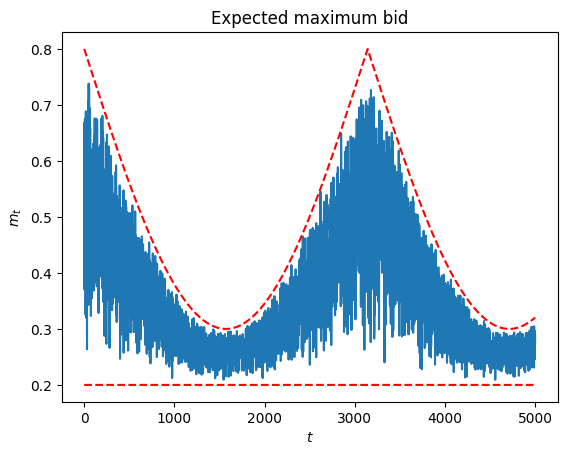

In [4]:
plt.plot(m_t)
plt.plot([pattern(t) for t in range(n_users)], 'r--')
plt.plot([0.2 for t in range(n_users)], 'r--')
plt.title('Expected maximum bid')
plt.xlabel('$t$')
plt.ylabel('$m_t$')
plt.show()

In [5]:
available_bids = np.linspace(0,1,K)
win_probabilities = np.array([sum(b > m_t)/n_users for b in available_bids])
print(win_probabilities)

[0.     0.     0.     0.4078 0.7052 0.8812 0.969  0.9982 1.     1.
 1.    ]


In [6]:
## Linear Program
c = -(my_valuation-available_bids)*win_probabilities
A_ub = [available_bids*win_probabilities]
b_ub = [rho]
A_eq = [np.ones(len(available_bids))]
b_eq = [1]
res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
gamma = res.x
print(f"Best policy is to pull arms with these probabilities:\n{gamma}")
print(f"Expected utility of the best policy: {res.fun}")
expected_clairvoyant_utilities = [-res.fun for u in range(n_users)]
expected_clairvoyant_bids = [sum(available_bids*gamma*win_probabilities) for u in range(n_users)]

Best policy is to pull arms with these probabilities:
[0.18260585 0.         0.         0.81739415 0.         0.
 0.         0.         0.         0.         0.        ]
Expected utility of the best policy: -0.39999999999999997


In [7]:
class HedgeAgent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.x_t = np.ones(K)/K
        self.a_t = None
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t

    def update(self, l_t):
        self.weights *= np.exp(-self.learning_rate*l_t)
        self.t += 1

In [8]:
class FFMultiplicativePacingAgent:
    def __init__(self, bids_set, valuation, budget, T, eta):
        self.bids_set = bids_set
        self.K = len(bids_set)
        self.hedge = HedgeAgent(self.K, np.sqrt(np.log(self.K)/T))
        self.valuation = valuation
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 1
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.bids_set[self.hedge.pull_arm()]

    def update(self, f_t, c_t, m_t):
        # update hedge
        f_t_full = np.array([(self.valuation-b)*int(b >= m_t) for b in self.bids_set])
        c_t_full = np.array([b*int(b >= m_t) for b in self.bids_set])
        L = f_t_full - self.lmbd*(c_t_full-self.rho)
        range_L = 2+(1-self.rho)/self.rho
        self.hedge.update((2-L)/range_L) # hedge needs losses in [0,1]
        # update lagrangian multiplier
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t),
                            a_min=0, a_max=1/self.rho)
        # update budget
        self.budget -= c_t

In [9]:
class Auction:
    def __init__(self, *args, **kwargs):
        pass

    def get_winners(self, bids):
        pass

    def get_payments_per_click(self, winners, values, bids):
        pass

    def round(self, bids):
        winners, values = self.get_winners(bids) # allocation mechanism!
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click


In [10]:
class FirstPriceAuction(Auction):
    def __init__(self, ctrs, n_slots):
        self.ctrs = ctrs
        self.n_adv = len(self.ctrs)
        self.n_slots = n_slots

    def get_winners(self, bids):
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)
        winner = adv_ranking[-self.n_slots:]
        return winner, adv_values

    def get_payments_per_click(self, winners, values, bids):
        payment = values[winners]/self.ctrs[winners]
        return payment.round(2)

In [11]:
eta = 1/np.sqrt(n_users) # from theory
agent = FFMultiplicativePacingAgent(bids_set = available_bids,
                                    valuation=my_valuation,
                                    budget=B,
                                    T=n_users,
                                    eta=eta)

# assuming all advertisers have the same CTR
auction = FirstPriceAuction(np.ones(n_advertisers+1), n_slots)

utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
total_wins = 0

counter = 0
np.random.seed(1)
for u in range(n_users):
    # interaction
    my_bid = agent.bid()
    if my_bid > my_valuation:
        counter+=1
    bids = np.append(my_bid, other_bids[:, u].ravel())
    winners, payments_per_click = auction.round(bids=bids)
    my_win = int(0 in winners)
    f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
    agent.update(f_t, c_t, m_t[u])
    # logging
    utilities = np.append(utilities, f_t)
    my_bids = np.append(my_bids, my_bid)
    my_payments = np.append(my_payments, c_t)
    total_wins+=my_win
print(f'Total # of Wins: {total_wins}')

Total # of Wins: 1539


The auctions agent bid higher than the product price 0.0 % of the time


(0.0, 60.0)

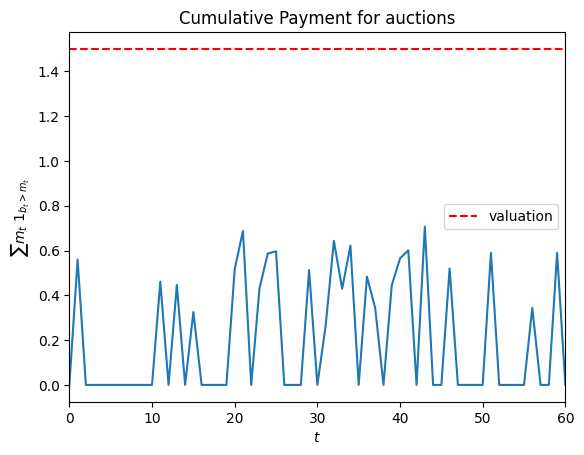

In [15]:
print(f"The auctions agent bid higher than the valuation {round(100*counter/(n_users),2)} % of the time")

plt.title('Cumulative Payment for auctions')
plt.plot(my_payments)
plt.axhline(my_valuation, color='red', linestyle='--', label='valuation')
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$\sum m_t~ 1_{b_t > m_t}$')
plt.xlim(0,60)

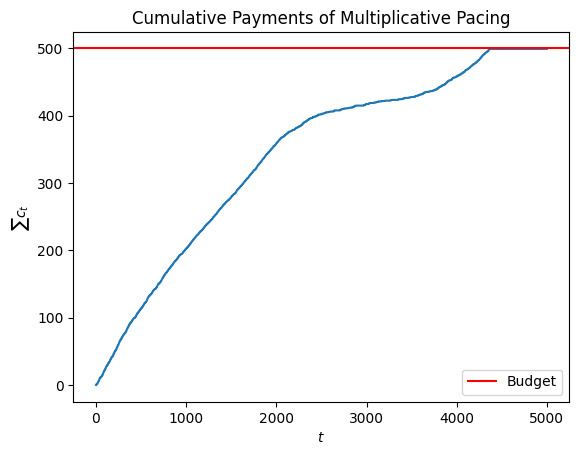

In [ ]:
cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

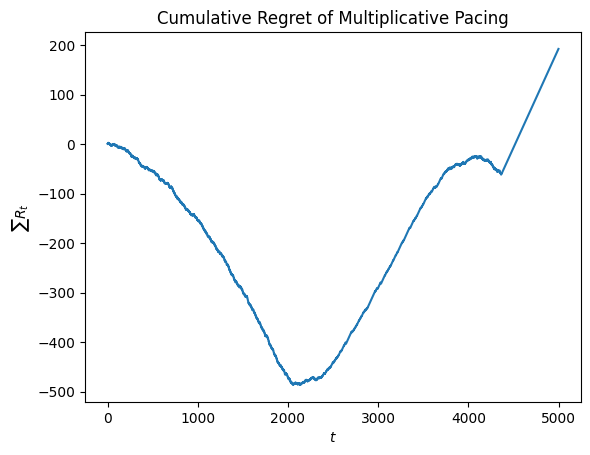

In [ ]:
cumulative_regret = np.cumsum(expected_clairvoyant_utilities-utilities)
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Multiplicative Pacing')
plt.show()